# Сравнение изображений: локальные признаки


В этом блокноте мы покажем практические cпособы нахождения углов и ключевых точек изображения; найдем на изображении линии, используя тот же метод, что применяется в автопилотах Tesla; посмотрим, как можно машинным образом сопоставить изображения, например, для распознавания объектов, создания панорам, реконструкции аффинных преобразований изображений и т.д.

In [1]:
!pip install opencv-python==4.4.0.42 opencv-contrib-python==4.4.0.42

  Using cached opencv-python-4.4.0.42.tar.gz (88.9 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib as mpl
from PIL import Image
# mpl.rcParams["figure.dpi"] = 200

## **Детектор Харриса**



Научимся применять детектор Харрисса средствами Python. Для начала считаем исходное изображение и выведем его на экран.

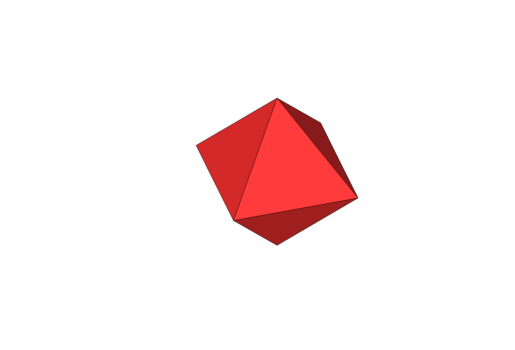

In [3]:
img = cv2.imread("/content/test.png")

plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Переведем наше изображение в градации серого и заменим целые значения на вещественные типа float32 - это обязательные требования для дальнейшего использования встроенной функции детектора Харриса.

In [4]:
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_1 = np.float32(img_1)

Теперь применим функцию `cv2.cornerHarris(image, blockSize, ksize, k)`, где

`image` - изображение (черно-белое и типа `float32`)

`blockSize` - размер соседства (т.е. для каждого пискеля учитывается размер блока _blockSize*blockSize_)

`ksize` - размер ядра Собеля, которое в _cv2_ используется для вычисления производных изображения по горизонтали и вертикали `Ix` и `Iy` в каждой точке изображения.
Параметр `ksize` может принимать значения 3, 5, 7 и т.д. (3x3, 5x5, ...). По мере увеличения размера все больше пикселей являются частью каждого процесса свертки, и края становятся более размытыми.

`k` - это эмпирическая константа, значения которой обычно 0.04 - 0.06. С большим `k` вы получите меньше ложных углов, но пропустите больше реальных углов (высокая точность), с меньшим `k`  получите намного больше углов, но пропустите меньше истинных углов, но получите много ложных (высокий отзыв).

Посмотрим на полученное изображение:

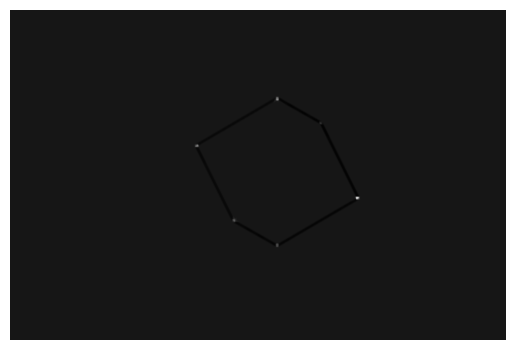

In [5]:
dst = cv2.cornerHarris(img_1, 10, 3, 0.04)

plt.axis("off")
plt.imshow(dst, cmap="gray")

Результат выполнения функции `cv2.cornerHarris` - некий массив с такой же размерностью, что и исходное изображение, в котором собраны вероятности "потенциальных" углов.

Давайте растянем наш результат с помощью функции `cv2.dilate`, чтобы увеличить светлые области и посмотрим на полученный результат (карту «угловых точек»):

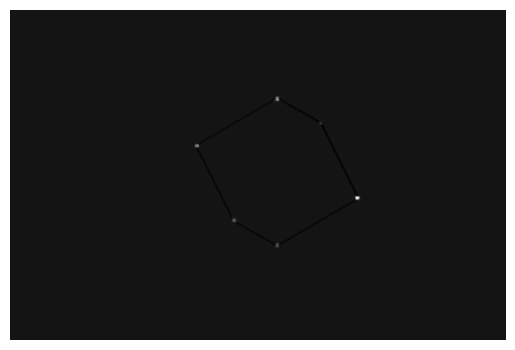

In [6]:
dst = cv2.dilate(dst, None)

plt.axis("off")
plt.imshow(dst, cmap="gray")

Осталось убрать значения меньше некого порогового (threshold) и наложить полученные угловые области на наше исходное изображение.

`Threshold` обычно определяется, как максимальное значение, умноженное на некий коэффициент, меньший единицы. Все , что меньше, останется в первоначальном виде, а то, что больше, можно окрасить в какой-то определенный цвет.

Коэффициент для определения `threshold` зависит от исходного изображения (чем меньше этот коэффициент, тем больше "потенциальных" углов мы увидим). Сейчас мы определим его равным 0.01 (выберем те, у которых вероятность отличается от мах не больше 1%), но самостоятельно рекомендуется попробовать другие величины.


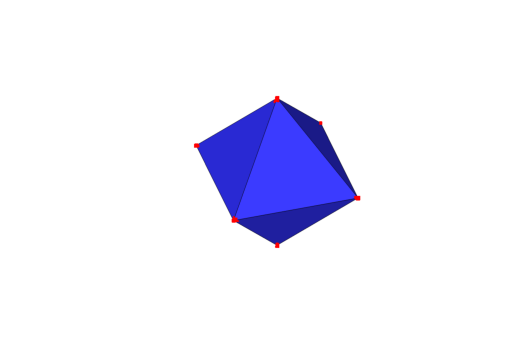

In [7]:
threshold = 0.01 * dst.max()
img[dst > threshold] = [255, 0, 0]
# [255, 0, 0] - области углов выделятся синим, [0, 255, 0] - зелёным, [0, 0, 255] - красным,
# [0, 0, 0] - чёрным, [255, 255, 255] - белым
plt.axis("off")
plt.imshow(img, cmap="gray")

Предлагается самостоятельно посмотреть, что метод Харриса инвариантен относительно поворота и не инвариантен к масштабированию. Для этого исходное изображение необходимо изменить с помощью, например, функций `cv2.flip(img, -1)` (0 - поворот относительно оси Х, 1 - Y, -1 - X и Y) или `cv2.resize(img, (width_new, high_new))`

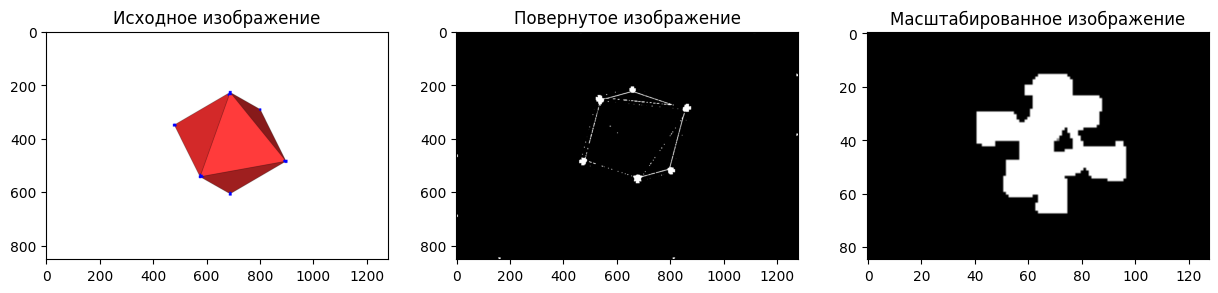

In [8]:
# Самостоятельное рассмотрение:
# Повернем изображение на 45 градусов по часовой стрелке

# Получаем размеры изображения
height, width = img.shape[:2]

# Вычисляем центр изображения
center_x, center_y = (width // 2, height // 2)

# Получаем матрицу поворота
M = cv2.getRotationMatrix2D((center_x, center_y), 45, 1.0)

# Выполняем поворот
rotated_img = cv2.warpAffine(img, M, (width, height))

# Применяем детектор Харриса к повернутому изображению
flipped_img_gray = cv2.cvtColor(rotated_img, cv2.COLOR_BGR2GRAY)
flipped_img_gray = np.float32(flipped_img_gray)
flipped_dst = cv2.cornerHarris(flipped_img_gray, 10, 3, 0.04)
flipped_dst = cv2.dilate(flipped_dst, None)

# Масштабируем
width_new = width // 10
height_new = height // 10
resized_img = cv2.resize(img, (width_new, height_new))

# Применяем детектор Харриса к масштабированному изображению
resized_img_gray = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
resized_img_gray = np.float32(resized_img_gray)
resized_dst = cv2.cornerHarris(resized_img_gray, 10, 3, 0.04)
resized_dst = cv2.dilate(resized_dst, None)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Исходное изображение")

axs[1].imshow(cv2.cvtColor(flipped_dst, cv2.COLOR_BGR2RGB))
axs[1].set_title("Повернутое изображение")

axs[2].imshow(cv2.cvtColor(resized_dst, cv2.COLOR_BGR2RGB))
axs[2].set_title("Масштабированное изображение")

plt.show()

Видим, что для повернутого изображения детектор отрабатывается хорошо, в то время как для масштабируемого - нет.

## **Детектор Ши-Томаси**

Данный детектор во многом совпадает с детектором Харриса, но различается в вычислении меры отклика: алгоритм напрямую вычисляет значение , поскольку делается предположение, что поиск углов будет более стабильным.

Рассмотрим применение детектора Ши Томаса средствами Python.

Считаем исходное изображение и сделаем его монохромным.

In [9]:
img = cv2.imread("/content/test.png")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

Применим функцию `cv2.goodFeaturesToTrack(image,maxCorners, qualityLevel, minDistance)`, где

`image` - изображение (черно-белое)

`maxCorners` - максимальное количество углов для поиска( если углов меньше, функция применится к "сильнейшим" углам)

`qualityLevel` - уровень качества, характеризующий минимальное качество угла на изображении (0-1)

`minDistance` - минимальная дистанция между углами




<ipython-input-10-1840ce70f2dc>:2: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners) # преобразуем в целые


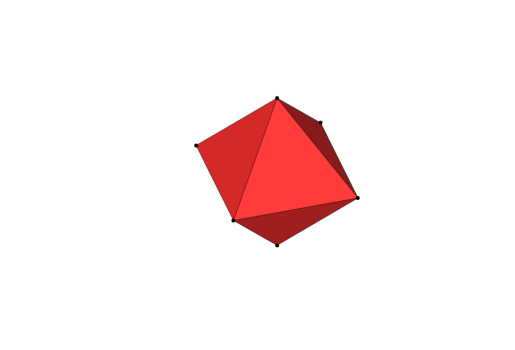

In [10]:
corners = cv2.goodFeaturesToTrack(gray, 6, 0.01, 5)
corners = np.int0(corners) # преобразуем в целые

for i in corners:
    x, y = i.ravel() # определяем координаты угла
    cv2.circle(img, (x, y), 5, [0, 0, 0], -1) # рисуем круг на исходном изображении, в указанном месте,
                                        # указанного радиуса (5), цвета с заливкой (-1)

plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## **Преобразование Хаффа**

Это метод обнаружения прямых и кривых линий на изображениях.
Используется в автопилотах Tesla.


Загрузим изображение и переведем его в градации серого:



In [11]:
mpl.rcParams["figure.dpi"] = 100

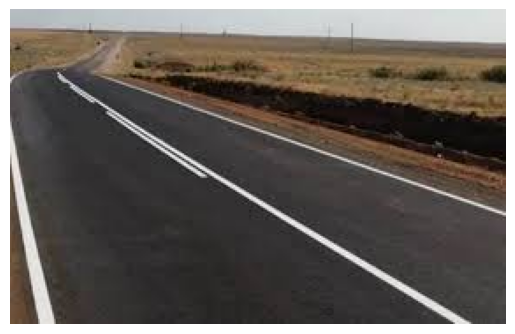

In [12]:
img = cv2.imread("/content/road.jpeg")

plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [13]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Определим границы изображения с помощью функции `cv2.Canny(image, threshold1, threshold2)`, где в качестве аргументов используется следующее:

`image` - исходное изображение (черно-белое)

`threshold1` - верхнее пороговое значение градиента интенсивности,

`threshold2` - нижнее пороговое значение градиента интенсивности.

Эта функция, как видно из названия, использует детектор границ Кенни.  



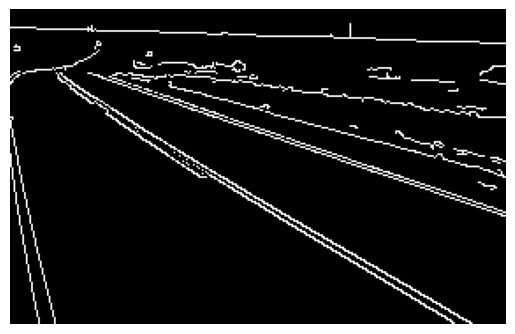

In [14]:
edges = cv2.Canny(gray, 150, 300)

plt.axis("off")
plt.imshow(edges, cmap="gray")

Можно самостоятельно поэкспериментировать с пороговыми значениями. Например, взять среднее значение интенсивности пикселей изображения (v = np.median(gray)) и вычислить отклонения от него с некоторым эмпирическим коэффициентом равным 0.33 по формулам: threshold1 = int(max(0, (1.0 - 0.33) * v))
threshold2 = int(min(255, (1.0 + 0.33) * v))

Теперь применим функцию cv2.HoughLinesP() для определения линий. Используем в качестве аргументов следующее: изображение границ, maxLineGap - максимальное расстояние между линиями,
minLineLength - минимальная длина линии, rho и theta - разрешение в пикселях и радианах, соответственно.
И нарисуем полученные линии:

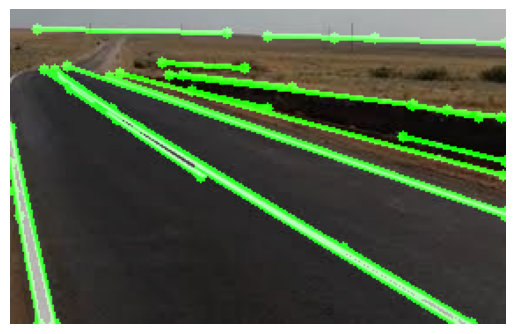

In [15]:
lines = cv2.HoughLinesP(edges, rho=1.0,theta=np.pi/180,threshold=20,minLineLength=30,maxLineGap=10)
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) #создание пустого изображение с той же длиной, высотой, спектром цветов как у img
line_color = [0, 255, 0]
line_thickness = 2
dot_color = [0, 255, 0]
dot_size = 3

for line in lines: #цикл задаёт отрезки
    for x1, y1, x2, y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), line_color, line_thickness)
        cv2.circle(line_img, (x1, y1), dot_size, dot_color, -1)
        cv2.circle(line_img, (x2, y2), dot_size, dot_color, -1)

final = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
# накладываем изображение с отрезками на начальное изображение
# 0.8 - alpha(задаёт вес первого изображения)
# 1.0 - beta(задаёт вес второго изображения)
# 0.0 - gamma(скалярная величина добавляемая к каждому изображению)

# Формула addWeighted: final = img * alpha + line_iplt.axis("off")

plt.axis("off")
plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

## **Дескриптор SIFT (Scale-Invariant Feature Transform)**

Загружаем исходное изображение, как GRAYSCALE:

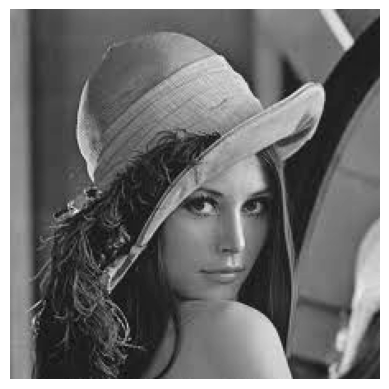

In [16]:
img = cv2.imread("/content/Lena.jpg", cv2.IMREAD_GRAYSCALE)

plt.axis("off")
plt.imshow(img, cmap="gray")

Создадим объект-алгоритм SIFT и найдём ключевые точки с помощью `sift.detectAndCompute(img)`.

Каждая ключевая точка - это некая структура, которая имеет множество атрибутов, таких, как координаты (x, y), размер значимой окрестности, угол, определяющий ее ориентацию, сила ключевых точек и т. д.

А дескриптор - это некий набор чисел для поиска ключевых точек на основе освещения, размера и направления, он хранит гистограмму ориентированных градиентов для области вокруг каждой ключевой точки.

Для примера выведем значения аттрибутов, которые пригодятся в дальнейшем, для нескольких ключевый точек.

In [17]:
sift = cv2.xfeatures2d.SIFT_create()
kp, des = sift.detectAndCompute(img, None)

for i in range(0,3):
    print("SIFT Keypoint:",i)
    print("Координаты ",kp[i].pt,"Размер ", kp[i].size, "Угол ", kp[i].angle)

SIFT Keypoint: 0
Координаты  (15.591696739196777, 182.9761505126953) Размер  2.3962228298187256 Угол  217.6338653564453
SIFT Keypoint: 1
Координаты  (16.123144149780273, 153.87867736816406) Размер  5.678529739379883 Угол  179.068359375
SIFT Keypoint: 2
Координаты  (16.41448402404785, 207.24119567871094) Размер  2.287032127380371 Угол  174.12124633789062



Воспользуемся встроенной функцией `cv2.drawKeyPoints()`, которая рисует окружности вокруг найденных ключевых точек. В качестве параметров этой функции указываем _наше изображение_, _множество контрольных точек_, _цвет_, _флаг_ (можно не указывать), если хотим, чтобы окружность имела размер ключевой точки и ориентацию (как мы знаем, направление ключевой точки вычисляется исходя из направлений градиентов точек, соседних с ней)

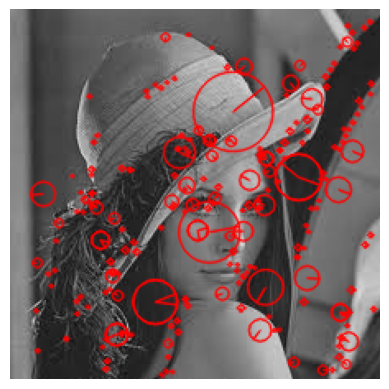

In [18]:
img_kp = cv2.drawKeypoints(img, kp,np.array([]), [255, 0, 0], cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.axis("off")
plt.imshow(img_kp, cmap="gray")

Давайте используем дескриптор SIFT для нахождения одного изображения в другом. Например, найдем в потоке машин определенный номерной знак. Усложним - перевернем знак.

Загрузим изображения в переведем их в градации серого:

In [19]:
img_1 = cv2.imread("/content/Num.jpg")
img_2 = cv2.imread("/content/trafic_jam.jpg")

In [20]:
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

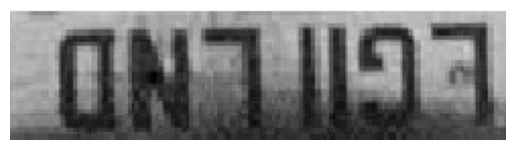

In [21]:
plt.axis("off")
plt.imshow(img_1, cmap="gray")

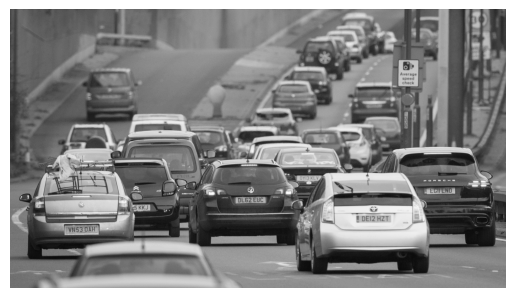

In [22]:
plt.axis("off")
plt.imshow(img_2, cmap="gray")

C помощью дескриптора SIFT находим контрольные точки и дескрипторы:

In [23]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_1, None)
kp2, des2 = sift.detectAndCompute(img_2, None)

Нам необходимо сопоставить контрольные точки и соответсвующие дескрипторы одного изображения с другим. Для этого можно использовать `BFMatcher` (Brute-force matcher):

In [24]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(des1,des2)

P.S.: `crossCheck=false` - совпадения вида один ко многим,

`crossCheck=true `- совпадения вида один к одному

Полученные совпадения в качестве аттрибутов имеют расстояние (по сути - это расстояние между двумя векторами, в нашем случае евклидово), индекс, соответсвующий первому изображению, индекс, соответсвующий второму изображению.

Отсортируем совпадения от лучшего к худшему в зависимости от аттрибута `distance` (чем меньше, тем лучше).

In [25]:
matches = sorted(matches, key = lambda x:x.distance)
print("Количество совпадений ", len(matches))

for i in range(0,3): #выведем первые 3
    print("Расстояние ",matches[i].distance,"Индекс 1 ",matches[i].trainIdx,"Индекс 2 ", matches[i].queryIdx)

Количество совпадений  76
Расстояние  317.0 Индекс 1  7175 Индекс 2  1
Расстояние  409.0 Индекс 1  7017 Индекс 2  60
Расстояние  413.0 Индекс 1  6861 Индекс 2  90


Выведем полученный результат для лучших 5 совпадений с помощью функции `cv2.drawMatches`, где укажем исходные изображения, контрольные точки (на этом шаге уже можем вернуться к исходным цветным).

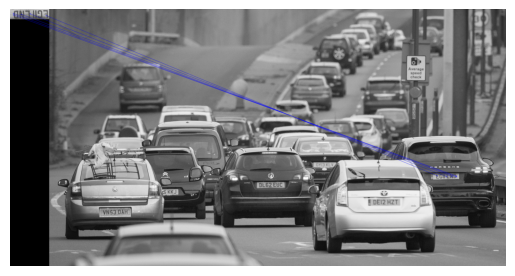

In [26]:
matching_result = cv2.drawMatches(img_1, kp1, img_2, kp2, matches[:5], None, [255, 0, 0], flags=2)

plt.axis("off")
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

А теперь попробуем сопоставить два изображения, используя дескриптор SIFT.

Загрузим изображения в переведем их в градации серого:

In [27]:
img_1 = cv2.imread("/content/tt_2.jpg")
img_2 = cv2.imread("/content/tt_1.jpg")
# img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
# img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

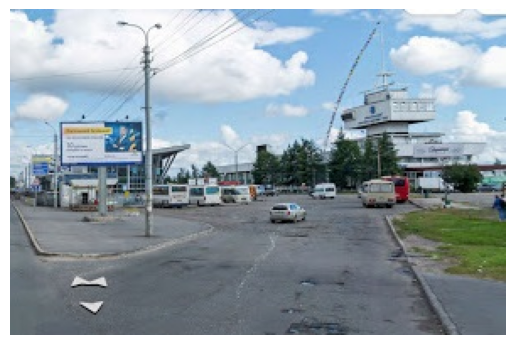

In [28]:
mpl.rcParams["figure.dpi"] = 100
plt.axis("off")
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

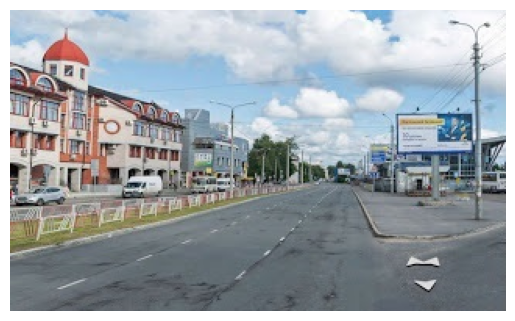

In [29]:
plt.axis("off")
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))

C помощью дескриптора SIFT находим контрольные точки и дескрипторы:

In [30]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_1, None)
kp2, des2 = sift.detectAndCompute(img_2, None)

Нам необходимо сопоставить контрольные точки и соответсвующие дескрипторы одного изображения с другим. Для этого можно использовать BFMatcher (Brute-force matcher):

In [31]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# crossCheck=false - совпадения вида один ко многим, crossCheck=true - совпадения вида один к одному
matches = bf.match(des1,des2)

Отсортируем совпадения от лучшего к худшему в зависимости от аттрибута distance (чем меньше, тем лучше), по сути это расстояние между двумя векторами.

In [32]:
matches = sorted(matches, key = lambda x:x.distance)
print("Количество совпадений ", len(matches))

for i in range(0,3): #выведем первые 3
    print("Расстояние ", matches[i].distance, "Индекс 1 ", matches[i].trainIdx, "Индекс 2 ", matches[i].queryIdx)

Количество совпадений  166
Расстояние  17.0 Индекс 1  405 Индекс 2  80
Расстояние  17.0 Индекс 1  419 Индекс 2  94
Расстояние  19.0 Индекс 1  391 Индекс 2  63


Посмотрим, что у нас получилось для самых лучших совпадений (первые 99):

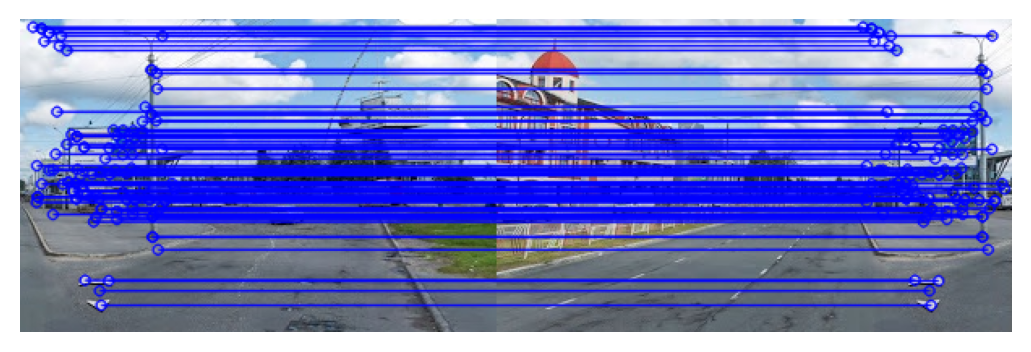

In [33]:
matching_result = cv2.drawMatches(img_1, kp1, img_2, kp2, matches[:99], None,[255,0,0], flags=2)
mpl.rcParams["figure.dpi"] = 200
plt.axis("off")
plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))

Теперь попробуем определить некую матрицу трансформации, которая переводит набор контрольных точек и и их дескрипторов одного изображения в аналогичный набор другого изображения.

Создадим новые наборы вещественного типа `float32`, в которых поменяем координаты контрольных точек (для первого изображения подставим координаты второго и наоборот). Но сделаем это только для совпавших контрольных точек, т.е. тех, что есть в `matches`.

А матрицу трансформации H найдем, используя подход `RANSAC` (о нем подробно рассказывалось в лекции) и функцию `cv2.findHomography`, в которую как раз и подадим наши новые наборы.

In [34]:
new1 = np.float32([kp1[m.queryIdx].pt for m in matches]) # координаты контрольной точки для 1-ого изображения
new2 = np.float32([kp2[m.trainIdx].pt for m in matches]) # координаты контрольной точки для 2-ого изображения
H, status = cv2.findHomography(new1, new2, cv2.RANSAC, 4.0)

Итак все готово, чтобы получить результирующее изображение. Мы ожидаем, что первое изображение сместится вправо, а второе наложиться на него , сдвинувшись влево.

Так и сделаем: применим к первому нашу матрицу трансформации, а сверху наложим второе.

Не будем концентрироваться на вычислении размера результирующего изображения. Грубо допустим, что оно будет в ширину явно меньше суммы исходных (они же должны наложиться со сдвигом), а в высоту не больше максимальной высоты двух исходных.

Обратите внимание, что на последней шаге мы использум изначальные изображения (не в оттенках серого).

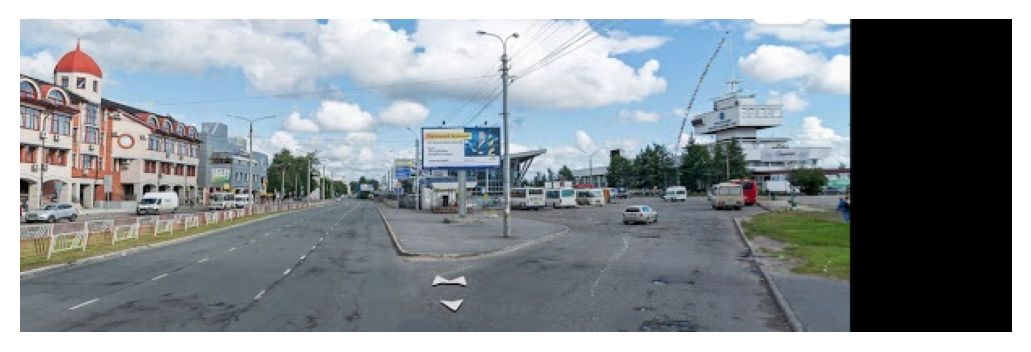

In [35]:
width = img_1.shape[1] + img_2.shape[1]
height = max(img_1.shape[0],img_2.shape[0])

# Трансформируем 1-ое изображение
result = cv2.warpPerspective(img_1, H, (width,height))
# Накладываем 2-ое изображение в крайний левый угол
result[0:img_2.shape[0], 0:img_2.shape[1]] = img_2

mpl.rcParams["figure.dpi"] = 200
plt.axis("off")
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

Получился ожидаемый результат (черная область появилась из-за грубой оценки размеров).

# Индивидуальное задание

1. С помощью библиотеки OpenCV считайте изображение.

2. Выделите подматрицу пикселей, находящихся на пересечении строк в диапазоне от 340 до 507, и столбцов в диапазоне от 549 до 741, матричного представления изображения (т.е. [340:507, 549:741]).

3. Определите разрешение кадрированного изображения.

    _Введите ширину кадрированного изображения в пикселях:_
    ```
    192
    ```
    
    _Введите высоту кадрированного изображения в пикселях:_
    ```
    167
    ```

4. Используйте дескриптор SIFT для нахождения одного изображения в другом
(кадрированного на исходном).
Не забудьте перевести их в градации серого.

5. Отсортируйте совпадения от лучшего к худшему в зависимости от аттрибута distance (чем меньше, тем лучше). Определите координаты нулевой ключевой точки.

    _Введите координату по горизонтали, округлив до целого:_
    ```
    597
    ```
    
    _Введите координату по вертикали, округлив до целого:_
    ```
    386
    ```

6. Определите интенсивность каналов B,G,R для полученной ключевой точки:

    _Введите значения интенсивности через запятую для каналов B,G,R соответственно. Значения введите через запятую, например, 25,25,25 или 25, 25, 25:_
    ```
    229,221,214
    ```

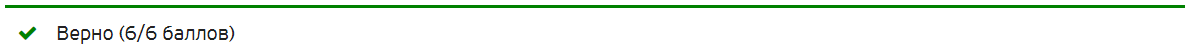

In [36]:
img = cv2.imread("/content/machine-2899796_1280.jpg")

crp = img[340:507, 549:741]

h, w = crp.shape[:2]

print(f"Ширина кадрированного изображения: {w} пикселей")
print(f"Высота кадрированного изображения: {h} пикселей")

sift = cv2.SIFT_create()

g_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
g_crp = cv2.cvtColor(crp, cv2.COLOR_BGR2GRAY)

kp_img, des_img = sift.detectAndCompute(g_img, None)
kp_crp, des_crp = sift.detectAndCompute(g_crp, None)

bf = cv2.BFMatcher()
mt = bf.match(des_img, des_crp)

mt = sorted(mt, key = lambda x:x.distance)

x = int(kp_img[mt[0].queryIdx].pt[0])
y = int(kp_img[mt[0].queryIdx].pt[1])

print(f"Координата по горизонтали: {x}")
print(f"Координата по вертикали: {y}")

b, g, r = img[y, x]
print(f"Интенсивность каналов B,G,R: {b},{g},{r}")

Ширина кадрированного изображения: 192 пикселей
Высота кадрированного изображения: 167 пикселей
Координата по горизонтали: 597
Координата по вертикали: 386
Интенсивность каналов B,G,R: 229,221,214
